<a href="https://colab.research.google.com/github/JavierPachas/tf_examples/blob/main/keras_regression_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed May 15 20:13:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install seaborn

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

try :
  #tensorflow_version only exists in Colab
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.15.0


In [4]:
dataset_path = keras.utils.get_file("housing.data","https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data")

   8192/Unknown - 0s 0us/step

In [5]:
dataset_path

'/root/.keras/datasets/housing.data'

In [6]:
column_names = ['CRIM',"ZN","INDUS","CHAS","NOX","RM","DIS","RAD","TAX",'PTRATIO',"B","MEDV"]

In [7]:
raw_dataset = pd.read_csv(dataset_path, names = column_names,
                          na_values = "?", comment = "\t",
                          sep =" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,,CRIM,ZN,INDUS,CHAS,NOX,RM,DIS,RAD,TAX,PTRATIO,B,MEDV
0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0
0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273.0,21.0,396.90,7.88,11.9


In [10]:
#dataset.isna().sum()
dataset = dataset.dropna()

In [11]:
train_dataset = dataset.sample(frac = 0.8, random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

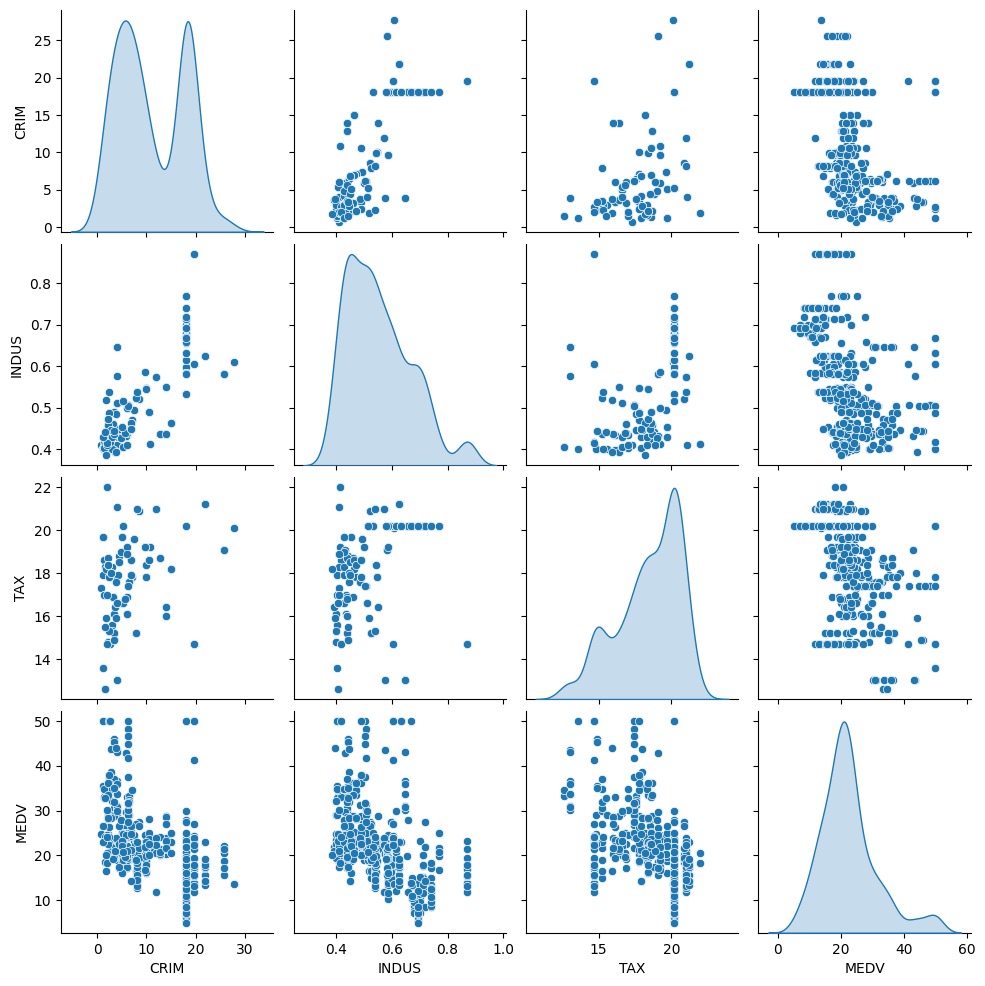

In [12]:
sns.pairplot(train_dataset[['CRIM','INDUS','TAX','MEDV']],
             diag_kind = 'kde')

In [13]:
train_stats = train_dataset.describe()
train_stats.pop('MEDV')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
CRIM,405.0,11.097951,6.699157,0.7400,5.3200,9.6900,18.1000,27.7400
ZN,405.0,0.069136,0.253999,0.0000,0.0000,0.0000,0.0000,1.0000
INDUS,405.0,0.553098,0.115564,0.3850,0.4490,0.5380,0.6240,0.8710
CHAS,405.0,6.269768,0.690552,3.5610,5.8780,6.1930,6.6190,8.7800
NOX,405.0,68.241975,27.908527,2.9000,45.0000,76.5000,94.1000,100.0000
RM,405.0,3.834098,2.162173,1.1296,2.0788,3.2721,5.2146,12.1265
DIS,405.0,9.474074,8.618564,1.0000,4.0000,5.0000,24.0000,24.0000
RAD,405.0,405.839506,164.057951,187.0000,284.0000,334.0000,666.0000,711.0000
TAX,405.0,18.437037,2.141275,12.6000,17.3000,18.8000,20.2000,22.0000
PTRATIO,405.0,356.276444,91.298597,2.6000,375.2100,391.2300,396.2400,396.9000


In [14]:
train_labels = train_dataset.pop('MEDV')
test_labels = test_dataset.pop('MEDV')

In [15]:
def norm(x):
  return (x-train_stats['mean']) / train_stats['std']

In [16]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [17]:
normed_train_data.tail()

,,CRIM,ZN,INDUS,CHAS,NOX,RM,DIS,RAD,TAX,PTRATIO,B
0.21038,20.0,-1.159542,-0.27219,-0.953564,0.785216,-1.291432,0.123303,-0.519121,-1.157149,-1.651837,0.444953,-1.098534
0.41238,0.0,-0.731129,-0.27219,-0.424853,1.293505,0.417723,-0.286008,-0.171035,-0.602467,-0.484308,0.173097,-0.885566
2.33099,0.0,1.266137,-0.27219,2.750874,-1.569423,0.915778,-1.065825,-0.519121,-0.017308,-1.745239,0.007816,2.211631
4.09740,0.0,1.266137,-0.27219,2.750874,-1.161054,1.137933,-1.120307,-0.519121,-0.017308,-1.745239,0.444953,1.943659
0.03738,0.0,-0.881895,-0.27219,-0.329668,0.058261,-1.065695,1.213734,-0.519121,-1.108386,0.823324,0.362805,-0.830561


In [18]:
 def build_model():
   model = keras.Sequential([
       layers.Dense(64, activation = 'relu',
                    input_shape = [len(train_dataset.keys())]),
       layers.Dense(64, activation = 'relu'),
       layers.Dense(1)
   ])

   optimizer = tf.keras.optimizers.RMSprop(0.001)

   model.compile(loss = 'mse',
                 optimizer = optimizer,
                 metrics = ['mae','mse'])

   return model

In [19]:
model = build_model()

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4993 (19.50 KB)
Trainable params: 4993 (19.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training a network

In [21]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 1s 885ms/step


array([[-2.84346968e-01],
       [ 1.18751794e-01],
       [ 2.44897753e-01],
       [ 1.09072000e-01],
       [ 1.36159360e-04],
       [-1.72714457e-01],
       [-4.35187817e-02],
       [-2.61996478e-01],
       [-1.93686962e-01],
       [-4.67333198e-01]], dtype=float32)

In [22]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end = '')

In [23]:
EPOCHS = 10000

In [ ]:
history = model.fit(
    normed_train_data, train_labels,
    epochs = EPOCHS, validation_split = 0.2, verbose = 0,
    callbacks = [PrintDot()]
)

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
9995,0.080488,0.203722,0.080488,15.853302,3.037861,15.853302,9995
9996,0.114714,0.245136,0.114714,14.689821,2.904674,14.689819,9996
9997,0.072183,0.193420,0.072183,14.473473,2.852957,14.473473,9997
9998,0.116079,0.269615,0.116079,15.304422,2.960946,15.304422,9998
9999,0.111686,0.256890,0.111686,15.490452,2.992277,15.490452,9999


In [26]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MEDV]')
  plt.plot(hist['epoch'], hist['mae'],
           label ='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error [$MEDV^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label = 'Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()

  plt.show()



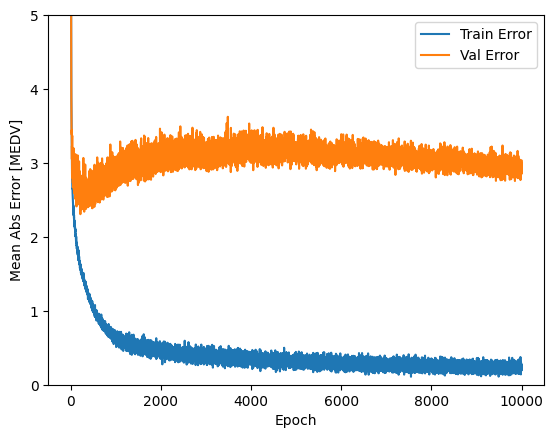

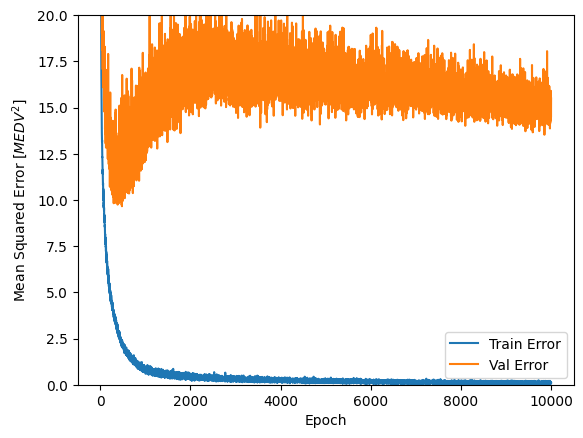

In [27]:
plot_history(history)

### Tuning a network

In [34]:
def build_model():
  model = keras.Sequential([
      layers.Dense(128, activation = 'relu',
                   input_shape = [len(train_dataset.keys())]),
      layers.Dropout(.5),
      layers.Dense(64, activation = 'relu'),
      layers.Dropout(.5),
      layers.Dense(32, activation = 'relu'),
      layers.Dropout(.5),
      layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss = 'mse',
                optimizer = optimizer,
                metrics = ['mae','mse'])

  return model

In [ ]:
model = build_model()
history = model.fit(
    normed_train_data, train_labels,
    epochs = EPOCHS, validation_split = 0.2, verbose = 0,
    callbacks = [PrintDot()]
)

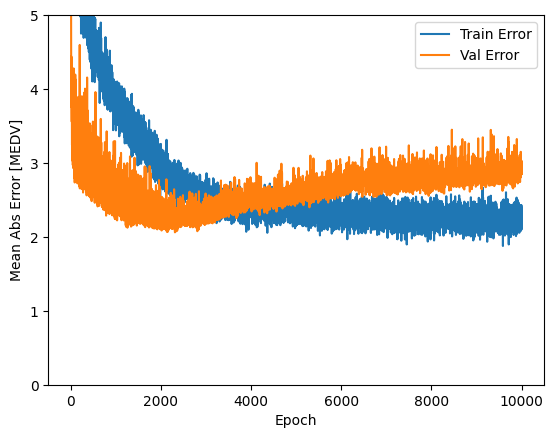

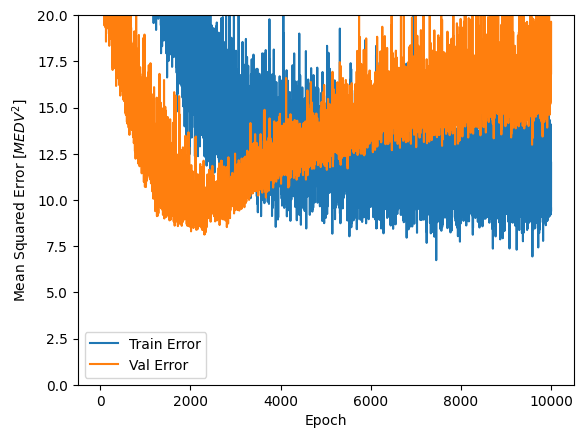

In [36]:
plot_history(history)

### Auto-stopping training


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

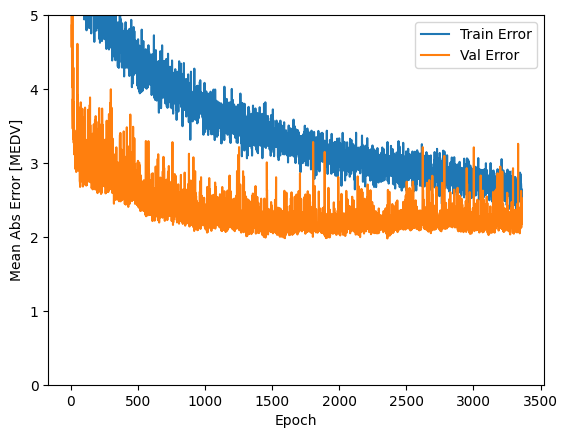

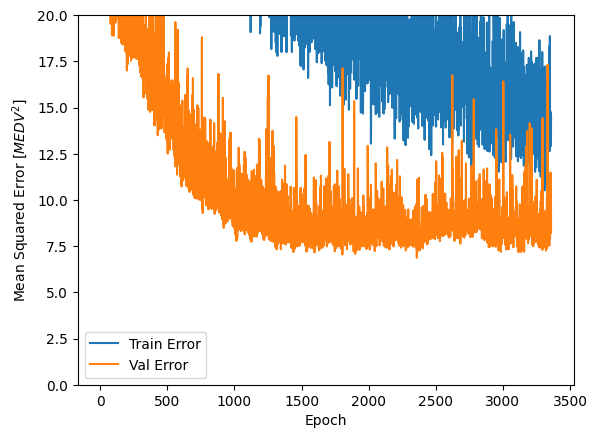

In [37]:
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=1000)
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
validation_split = 0.2, verbose=0,
callbacks=[early_stop, PrintDot()])
plot_history(history)

In [38]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose = 0)
print("Testing set Mean Abs Error: {:5.2f} MEDV".format(mae))

Testing set Mean Abs Error:  1.91 MEDV


4/4 [==============================] - 0s 3ms/step


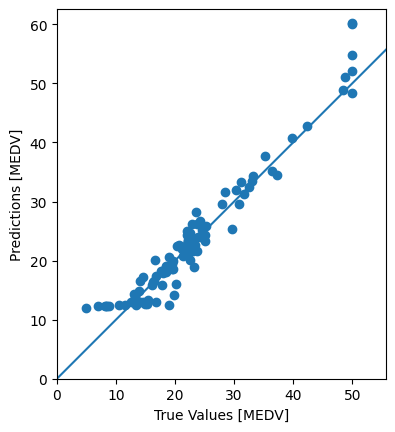

In [39]:
test_predictions = model.predict(normed_test_data).flatten()
plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values [MEDV]")
plt.ylabel("Predictions [MEDV]")
plt.axis("equal")
plt.axis("square")
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

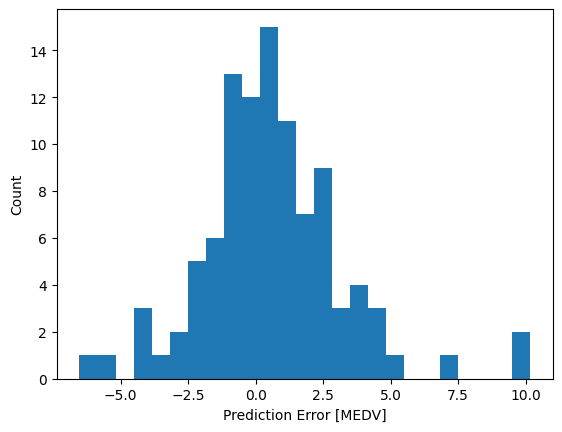

In [40]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MEDV]")
_ = plt.ylabel("Count")